## **Перша модель**

Сформулюємо завдання

In [1]:
# Для початку сформулюємо нашу задачу за допомогою функції LaTeX
from IPython.display import display, Math

# Створення текстового представлення умови задачі у вигляді LaTeX
task_description = r"""
\text{Знайти чисельний розв'язок рівняння:}
$$
\frac{\partial S}{\partial x} = \alpha \frac{\partial^2 S}{\partial x^2} + \beta \frac{\partial^2 S}{\partial y^2}, \quad (x, y) \in [-5; 5] \times [0; 10].
$$
\text{Значення параметрів: } \alpha = 3, \beta = 4. \\
\text{Граничні умови:}
$$
S(-5, y) = 1, \, y \in [5; 10], \quad \left. \frac{\partial S}{\partial x} \right|_{(-5, y)} = 0, \, y \in [0; 5];
$$
$$
S(5, y) = 0, \, y \in [0; 5], \quad \left. \frac{\partial S}{\partial x} \right|_{(5, y)} = 0, \, y \in (5; 10];
$$
$$
S(x, 10) = 1, \, x \in [-5; 0], \quad \left. \frac{\partial S}{\partial y} \right|_{(x, 10)} = 0, \, x \in (0; 5];
$$
$$
S(x, 0) = 0, \, x \in [0; 5], \quad \left. \frac{\partial S}{\partial y} \right|_{(x, 0)} = 0, \, x \in [-5; 0).
$$
"""

# Відображення умови задачі
display(Math(task_description))

<IPython.core.display.Math object>

Для розв'язку я обрала прямий (матричний) метод, оскільки він швидший для доволі "простих" задач на відміну від ітераційних методів (це висновок ще із першої лабораторної роботи). Розв'язок із коментарями наведений нижче:

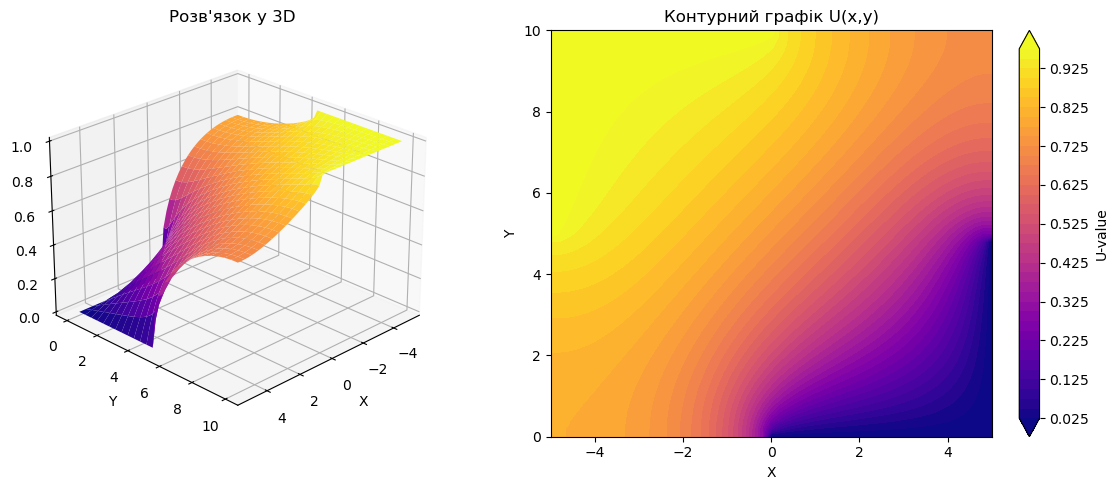

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import splu

# ---------------------------
# Параметри задачі, задання області та побудова сітки
# ---------------------------
a_coeff = 3.0
b_coeff = 4.0

xmin, xmax = -5.0, 5.0
ymin, ymax = 0.0, 10.0

Nx = 51
Ny = 51

dx = (xmax - xmin) / (Nx - 1)
dy = (ymax - ymin) / (Ny - 1)

x_coords = np.linspace(xmin, xmax, Nx)
y_coords = np.linspace(ymin, ymax, Ny)

# ---------------------------
# Індекси для особливих граничних умов
# ---------------------------
j_split = 25  # для y=5
i_split = 25  # для x=0

def linear_index(ix, iy):
    return ix * Ny + iy

def build_system():
    """Побудова розрідженої системи рівнянь A*U = b."""
    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)
    
    # Пройдемося по сітці
    for jj in range(Ny):
        for ii in range(Nx):
            row_id = linear_index(ii, jj)
            
            # Перевірка граничних умов
            if ii == 0:    # Ліва межа (гранична умова Неймана)
                if jj >= j_split:
                    A[row_id, row_id] = 1.0
                    b[row_id] = 1.0   # Діріхле (фіксоване значення)
                else:
                    A[row_id, row_id] = 1.0
                    A[row_id, linear_index(ii+1, jj)] = -1.0  # Нейман (похідна)
                continue
            
            if ii == Nx - 1:  # Права межа (гранична умова Неймана)
                if jj < j_split:
                    A[row_id, row_id] = 1.0
                    b[row_id] = 0.0  # Діріхле (фіксоване значення)
                else:
                    A[row_id, row_id] = 1.0
                    A[row_id, linear_index(ii-1, jj)] = -1.0  # Нейман (похідна)
                continue
            
            if jj == Ny - 1:  # Верхня межа (гранична умова Діріхле)
                if ii <= i_split:
                    A[row_id, row_id] = 1.0
                    b[row_id] = 1.0   # Діріхле (фіксоване значення)
                else:
                    A[row_id, row_id] = 1.0
                    A[row_id, linear_index(ii, jj-1)] = -1.0  # Нейман (похідна)
                continue
            
            if jj == 0:   # Нижня межа (гранична умова Діріхле)
                if ii >= i_split:
                    A[row_id, row_id] = 1.0
                    b[row_id] = 0.0   # Діріхле (фіксоване значення)
                else:
                    A[row_id, row_id] = 1.0
                    A[row_id, linear_index(ii, jj+1)] = -1.0   # Нейман (похідна)
                continue
            
            # Внутрішні точки
            c_im1j = a_coeff/(dx**2) + 1.0/(2*dx)
            c_ip1j = a_coeff/(dx**2) - 1.0/(2*dx)
            c_ijm1 = b_coeff/(dy**2)
            c_ijp1 = b_coeff/(dy**2)
            c_ij = -2*a_coeff/(dx**2) - 2*b_coeff/(dy**2)
            
            A[row_id, linear_index(ii, jj)]   = c_ij
            A[row_id, linear_index(ii-1, jj)] = c_im1j
            A[row_id, linear_index(ii+1, jj)] = c_ip1j
            A[row_id, linear_index(ii, jj-1)] = c_ijm1
            A[row_id, linear_index(ii, jj+1)] = c_ijp1
            
            b[row_id] = 0.0
    
    return A, b

def plot_results(U_matrix):
    """Візуалізація отриманого розв'язку."""
    X, Y = np.meshgrid(x_coords, y_coords)
    
    fig = plt.figure(figsize=(12,5))
    
    # 3D поверхня 
    ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
    surface_plot = ax_3d.plot_surface(X, Y, U_matrix.T, cmap='plasma')
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('U')
    ax_3d.set_title('Розв\'язок у 3D')
    ax_3d.view_init(elev=25, azim=45)
    
    # Контурний 2D графік
    ax_2d = fig.add_subplot(1, 2, 2)
    contour_levels = 40
    contour_plot = ax_2d.contourf(x_coords, y_coords, U_matrix.T, contour_levels, cmap='plasma', extend='both')
    ax_2d.set_xlabel('X')
    ax_2d.set_ylabel('Y')
    ax_2d.set_title('Контурний графік U(x,y)')
    fig.colorbar(contour_plot, ax=ax_2d, label='U-value')
    
    plt.tight_layout()
    plt.show()

def main():
    # Побудова системи
    A, b = build_system()
    
    # Переводимо в формат CSC для splu
    A = A.tocsc()
    
    # Виконуємо LU-факторизацію та розв'язок
    A_lu = splu(A)
    S_flat = A_lu.solve(b)
    S_matrix = S_flat.reshape((Nx, Ny))
    
    # Візуалізація результатів
    plot_results(S_matrix)

if __name__ == "__main__":
    main()